In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import scipy.sparse
import cmasher as cmr
from natsort import natsorted
import sys
import os

c:\Users\bence\Projects\BIO446\env\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
c:\Users\bence\Projects\BIO446\env\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
c:\Users\bence\Projects\BIO446\env\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
c:\Users\bence\Projects\BIO446\env\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
c:\Users\bence\Projects\BIO446\env\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import annd

In [2]:
sys.path.append(os.path.abspath(r"C:\\Users\\bence\\Projects\\BIO446\\McKinnon-Rosati-Laboratory\\Project 2\\jl_modules"))

In [3]:
from collections import OrderedDict
import decoupler as dc
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 pynndescent==0.5.13


In [4]:
clustered_file = "C:\\Users\\bence\\Projects\\BIO446\\McKinnon-Rosati-Laboratory\\Project 2\\granuloma 30\\results\\granulomas_clustered.h5ad"

In [5]:
# clustered data
adata = sc.read_h5ad(clustered_file)
adata.uns['log1p']["base"] = None    # bug fix

print(adata.obs['sample'].value_counts())
print()
print('X matrix is sparse:', scipy.sparse.issparse(adata.X))
print('X size =', adata.X.shape)

sample
granuloma2    9392
granuloma1    9302
granuloma3    8909
Name: count, dtype: int64

X matrix is sparse: False
X size = (27603, 23693)


In [6]:
adata

AnnData object with n_obs × n_vars = 27603 × 23693
    obs: 'scDblFinder_score', 'scDblFinder_class', 'doublet', 'n_genes_by_counts', 'total_counts', 'type', 'sample', 'batch_type', 'batch', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'size_factors', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1.0', 'leiden_1.4', 'leiden_1.7', 'leiden_2.0', 'leiden_2.5', 'leiden_3.0', 'leiden_3.5', 'leiden_4.0', 'leiden_4.5', 'hclust', 'kmeans'
    var: 'gene_ids', 'feature_types', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'n_cells_by_counts-2', '

In [7]:
i=0
new_col = []
for item in adata.obs['leiden_1.4']:
    if item == '14' and adata.obs['leiden_3.5'].iloc[i] == '45':
        new_col.append('14b')
    elif item == '9' and adata.obs['leiden_3.0'].iloc[i] == '23':
        new_col.append('9b')
    elif item == '5' and adata.obs['leiden_2.5'].iloc[i] == '38':
        new_col.append('5b')
    elif item == '3' and adata.obs['leiden_1.7'].iloc[i] == '28':
        new_col.append('3b')
    elif item == '7' and adata.obs['leiden_4.0'].iloc[i] == '52':
        new_col.append('7c')
    elif item == '7' and adata.obs['leiden_4.0'].iloc[i] == '38':
        new_col.append('7b')
    elif item == '11' and adata.obs['leiden_4.5'].iloc[i] == '27':
        new_col.append('11c')
    elif item == '11' and adata.obs['hclust'].iloc[i] == '40':
        new_col.append('11b')
    elif item == '4' and adata.obs['leiden_4.0'].iloc[i] == '4':
        new_col.append('4a')
    elif item == '1' and adata.obs['leiden_1.7'].iloc[i] == '6':
        new_col.append('1b')
    else:
        new_col.append(item)
    i = i+1
adata.obs['my_clust_1'] = new_col
adata.obs['my_clust_1'] = adata.obs['my_clust_1'].astype('category')

In [8]:
cluster_type = "my_clust_1"
new_order = list(adata.obs[cluster_type].cat.categories)
print(new_order)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '4', '4a', '5', '6', '7', '7c', '8', '9']


In [9]:
remove = ['16','26'] # remove clusters 16 and 26
for cluster in remove:
    adata = adata[adata.obs[cluster_type] !=cluster, :]
# update new_order
new_order = [item for item in new_order if item not in remove]
print(new_order)

['0', '1', '10', '11', '12', '13', '14', '15', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '27', '28', '29', '3', '30', '4', '4a', '5', '6', '7', '7c', '8', '9']


In [10]:
i=0
new_col = []
for item in adata.obs['my_clust_1']:
    if item == '14b':
        new_col.append('14')
    else:
        new_col.append(item)
    i = i+1

adata.obs['my_clust_1'] = new_col
adata.obs['my_clust_1'] = adata.obs['my_clust_1'].astype('category')

C:\Users\bence\AppData\Local\Temp\ipykernel_53324\1375893582.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['my_clust_1'] = new_col


In [11]:
old_order = list(adata.obs[cluster_type].cat.categories)
print(list(adata.obs[cluster_type].cat.categories))

['0', '1', '10', '11', '12', '13', '14', '15', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '27', '28', '29', '3', '30', '4', '4a', '5', '6', '7', '7c', '8', '9']


In [12]:
new_order = ['4a','4', '1', '1b', '2', '10', '7', '7b', '7c',
            '13', '23', '5', '5b',
            '3', '3b',
            '11b', '0', '21', '8',  '11c','11',
            '20',
            '18', '14', '25',
             '9', '24', '9b', '27',
             '15', '17',
             '22', '12', '19', '6',]
print( [item for item in old_order if item not in new_order] )
print( [item for item in new_order if item not in old_order] )

['28', '29', '30']
['1b', '7b', '5b', '3b', '11b', '11c', '9b']


<Axes: title={'center': 'Mki67'}, xlabel='UMAP1', ylabel='UMAP2'>

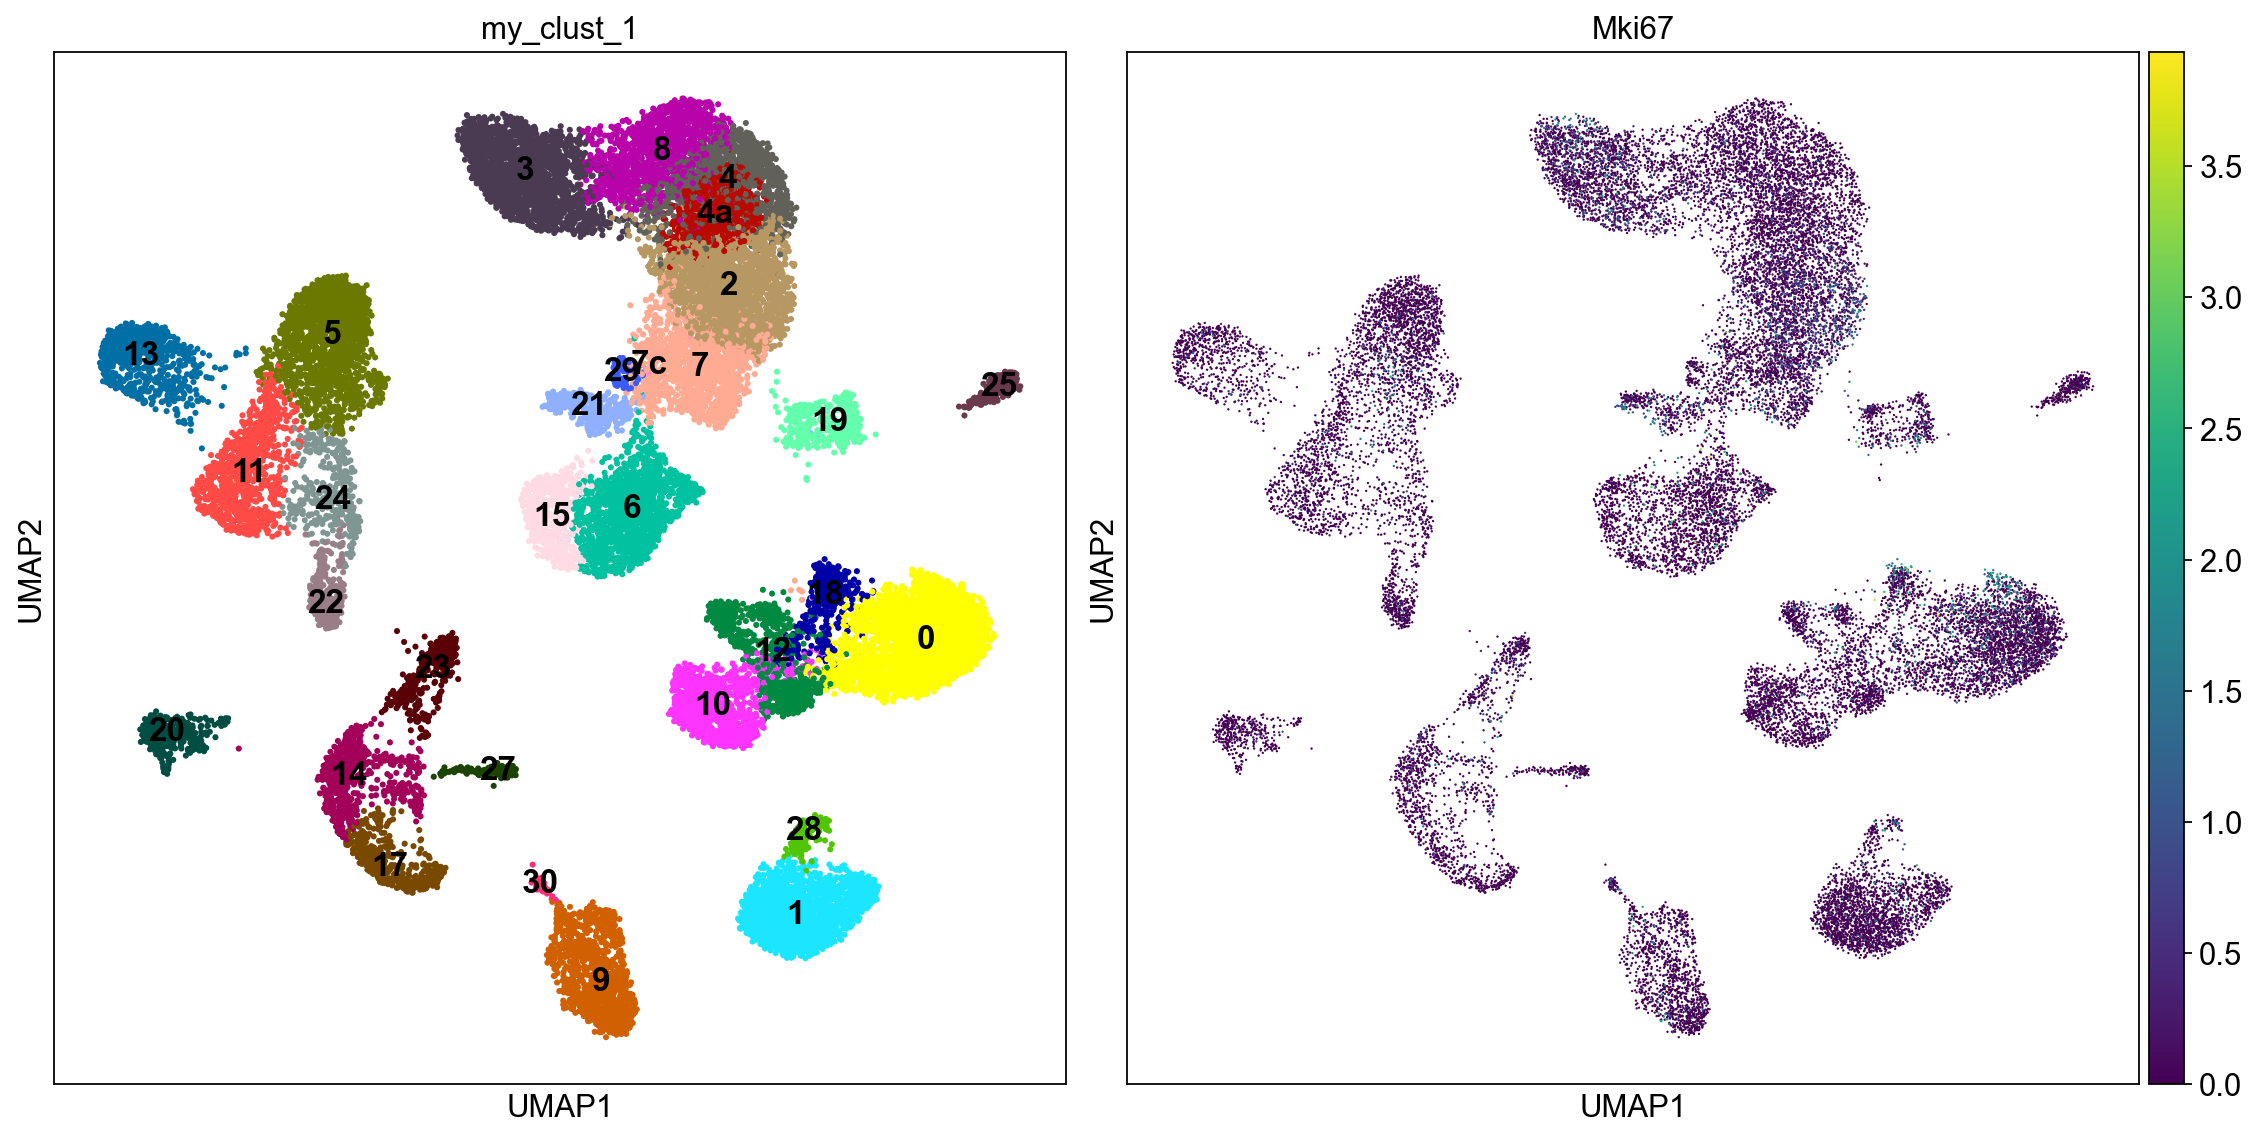

In [13]:
test_gene = 'Mki67' # 'Sgms1' 'Sgms2' 'Sphk1'
plt.rcParams.update({'font.size': 15})   # cluster labels
fig, axs = plt.subplots(1, 2, figsize=(14,7),constrained_layout=True)
sc.pl.umap(adata, color=cluster_type, size=30, ax=axs[0], show=False, legend_loc='on data')
sc.pl.umap(adata,  color=test_gene, ax=axs[1], show=False)

In [14]:
annotation_dict= {
'9': 'CAP1',
'24': 'CAP2',
'9b': 'VEC',
'27': 'LEC',

'17': 'Ciliated',
'15': 'Secretory',
'22': 'AT1',
'6': 'AT2',
'12': 'AT2-i1',
'19': 'AT2-i2',

'18': 'AF1',
'14': 'AF2',
'14b': 'AF2',
'25': 'Pericyte',

'20': 'Mesothelial',

'3': 'B1',
'3b': 'B2',

'11b': 'NK',
'0': 'Treg1',
'21': 'Treg2',
'8': 'TCM',
'11c': 'T1',
'11': 'T2',

'4a': 'AM',
'4': 'M-i1',
'1': 'M-i1',
'1b': 'M-i1',
'10': 'M-lc',
'2': 'M-i1',
'7': 'M-i2',
'7b': 'M-C1q',
'7c': 'iMon',

'23': 'pDC',
'13': 'DC',
'5b': 'N1',
'5': 'N2',
}

# Add cell type column based on annotation
# adata.obs['cell_type_edit'] = [annotation_dict[clust] for clust in adata.obs[cluster_type]]

myList = []
for clust in adata.obs[cluster_type]:
    if (clust in annotation_dict):
        myList.append(annotation_dict[clust])
    else: myList.append('None')
    
adata.obs['cell_type_edit'] = myList

In [15]:
pal1 = {
'CAP1': '#D1F8B0',
'CAP2': '#E59637',
'AEC': '#cb3329',
'VEC': '#FCCDE5',
'LEC': '#74008B',
'Ciliated': '#A473B0',
'Secretory': '#158364',
'AT1': '#79BAFF',
'AT2': '#FDB462',
'AT2-i1': '#80B1D3',
'AT2-i2': '#FB8072',
'AF1': '#CCEBC5',
'AF2': '#33A02C',
'Pericyte': '#526FBD',
'SMC': '#99DDFF',
'Mesothelial': '#FF5A48',
'B1': '#CAFFFE',
'B2': '#9B7DB7',
'NK': '#ce4432',
'Treg1': '#529CB4',
'Treg2': '#C2AA36',
'TCM': '#EE8866',
'T prolif': '#C7221F',
'T1': '#4D8CC4',
'T2': '#98B299',
'AM': '#4D8CC4',
'M-lc': '#44BB99',
'M-C1q': '#FF6DB6',
'M-i1': '#CCEBC5',
'M-i2': '#FFFFB3',
'iMon': '#FF5A48',
'DC': '#4e9cbd',
'pDC': '#E04E29',
'N1': '#C2AA36',
'N2': '#BEBADA',
}

In [16]:
adata = adata[adata.obs['cell_type_edit'] != 'None']

unique_celltype_sub = adata.obs['cell_type_edit'].unique()

# display unique cells
print(unique_celltype_sub)


num_unique_celltype_sub = adata.obs['cell_type_edit'].nunique()

print(f"Number of unique sub cell types: {num_unique_celltype_sub}")

['N2' 'M-i1' 'B1' 'AT2-i2' 'Treg1' 'M-i2' 'DC' 'AT2' 'Treg2' 'AM' 'CAP2'
 'Ciliated' 'CAP1' 'AF2' 'T2' 'LEC' 'TCM' 'Pericyte' 'Mesothelial'
 'AT2-i1' 'AT1' 'M-lc' 'AF1' 'pDC' 'Secretory' 'iMon']
Number of unique sub cell types: 26


In [17]:
# map cell types to integers
replacement_dict = {
    'AT2': 0,
    'B1': 1,
    'M-i1': 2,
    'DC': 3,
    'Treg1': 4,
    'M-i2': 5,
    'Secretory': 6,
    'AM': 7,
    'N1': 8,
    'M-C1q': 9,
    'AT2-i2': 10,
    'AF1': 11,
    'VEC': 12,
    'AF2': 13,
    'CAP1': 14,
    'N2': 15,
    'AT2-i1': 16,
    'Pericyte': 17,
    'pDC': 18,
    'Ciliated': 19,
    'NK': 20,
    'AT1': 21,
    'TCM': 22,
    'Treg2': 23,
    'M-lc': 24,
    'Mesothelial': 25,
    'T2': 26,
    'T1': 27,
    'CAP2': 28,
    'LEC': 29,
    'iMon': 30,
    'B2': 31,
}

In [18]:
# replace cell types with their integers
adata.obs['celltype'] = adata.obs['cell_type_edit'].replace(replacement_dict)


print("Unique values in 'celltype' column after replacement:", adata.obs['celltype'].unique())

C:\Users\bence\AppData\Local\Temp\ipykernel_53324\1508046432.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs['celltype'] = adata.obs['cell_type_edit'].replace(replacement_dict)
C:\Users\bence\AppData\Local\Temp\ipykernel_53324\1508046432.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['celltype'] = adata.obs['cell_type_edit'].replace(replacement_dict)


Unique values in 'celltype' column after replacement: [15  2  1 10  4  5  3  0 23  7 28 19 14 13 26 29 22 17 25 16 21 24 11 18
  6 30]


In [19]:
# number of cells in each cell type
cell_type_counts = adata.obs['celltype'].value_counts()

print("Number of cells in each cell type:")
print(cell_type_counts)

Number of cells in each cell type:
celltype
2     5241
4     2965
1     1994
15    1772
0     1483
5     1473
22    1362
14    1168
24    1075
26     923
16     897
7      782
3      699
13     628
6      536
19     464
11     458
10     416
25     400
23     367
21     363
18     359
28     351
17     284
29     138
30       3
Name: count, dtype: int64


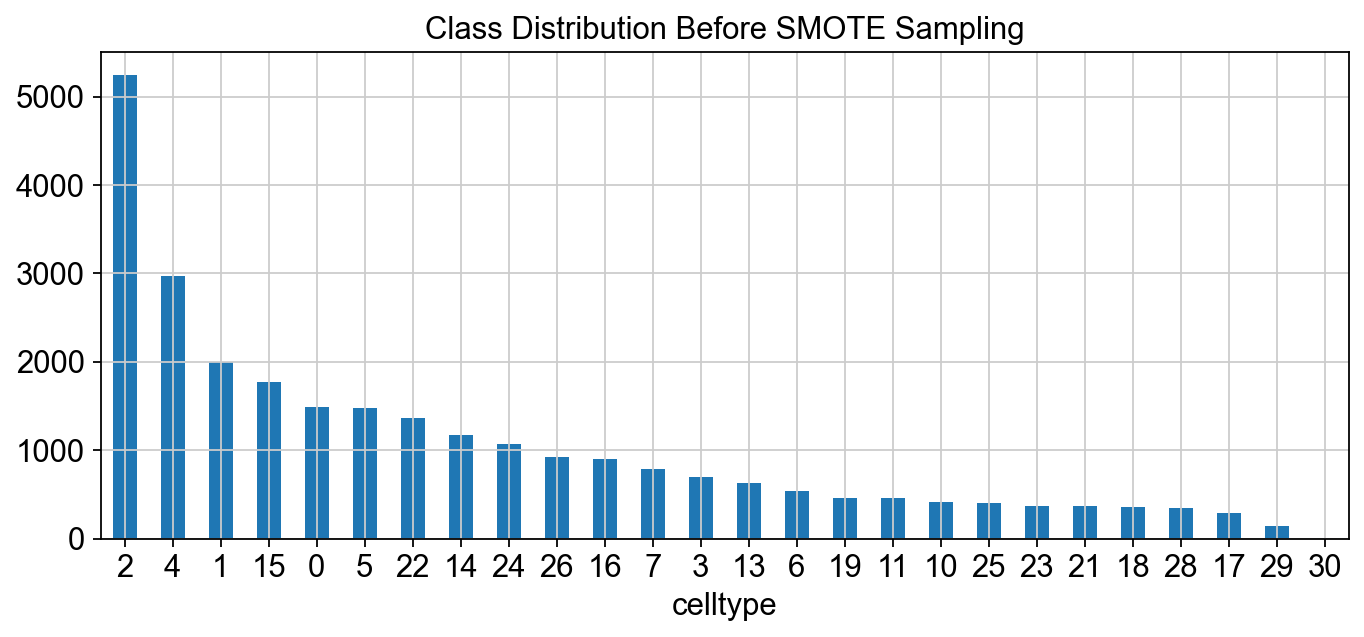

In [20]:
y = adata.obs['celltype']

# plot class distrubition before smote
plt.figure(figsize=(10, 4))
plt.title('Class Distribution Before SMOTE Sampling')
y.value_counts().plot(kind='bar', rot=0)

plt.show()

Original class distribution: Counter({2: 5241, 4: 2965, 1: 1994, 15: 1772, 0: 1483, 5: 1473, 22: 1362, 14: 1168, 24: 1075, 26: 923, 16: 897, 7: 782, 3: 699, 13: 628, 6: 536, 19: 464, 11: 458, 10: 416, 25: 400, 23: 367, 21: 363, 18: 359, 28: 351, 17: 284, 29: 138, 30: 3})
Resampled class distribution: Counter({15: 5241, 2: 5241, 1: 5241, 10: 5241, 4: 5241, 5: 5241, 3: 5241, 0: 5241, 23: 5241, 7: 5241, 28: 5241, 19: 5241, 14: 5241, 13: 5241, 26: 5241, 29: 5241, 22: 5241, 17: 5241, 25: 5241, 16: 5241, 21: 5241, 24: 5241, 11: 5241, 18: 5241, 6: 5241, 30: 5241})


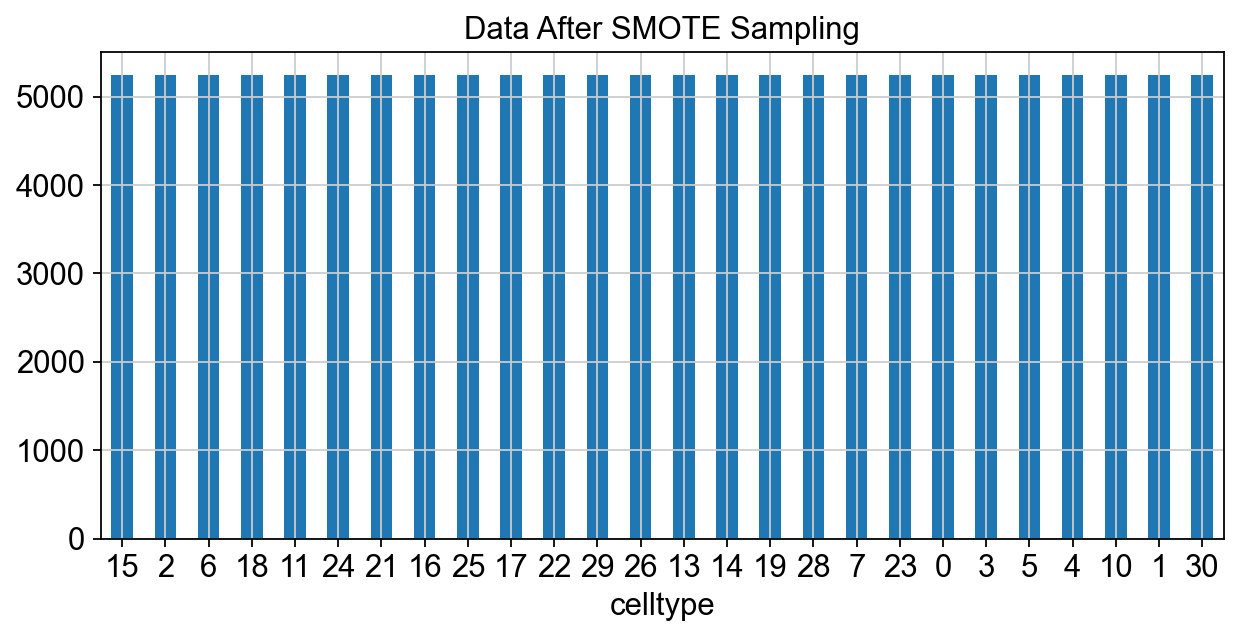

In [21]:
from imblearn.over_sampling import SMOTE
from collections import Counter

y = adata.obs['celltype']

# convert to dense array
X = adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X

# apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

#new class distribution
print(f"Original class distribution: {Counter(y)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")

# convert resampled labels to a Pandas Series for easy plotting
y_resampled_series = pd.Series(y_resampled)

# class distribution after SMOTE
plt.figure(figsize=(9, 4))
plt.title('Data After SMOTE Sampling')
y_resampled_series.value_counts().plot(kind='bar', rot=0)
plt.show()

In [48]:
from sklearn.model_selection import train_test_split
# Extract gene expression values (X) and cell types (y) from the adata object
# If adata.X is already a numpy array, just use it directly
X = adata.X  # No need for .toarray() if it's already a numpy array
y = adata.obs['celltype'].values  # Extract the cell types as a numpy array

# Split the data into training and testing sets
'''X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)'''

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state=42)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size = 0.25, random_state=42)

train_features = np.array(train_features)
test_features = np.array(test_features)
val_features = np.array(val_features)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

# Print the shape of the training and testing sets
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (15960, 23693)
Validation features shape: (5320, 23693)
Test features shape: (5321, 23693)
Training labels shape: (15960,)
Validation labels shape: (5320,)
Test labels shape: (5321,)


In [49]:
print(y)
print(len(y))

[15  2  1 ...  2  2 21]
26601


In [50]:
print(X)
print(len(X))

[[0.         0.         0.         ... 0.         0.         0.6738115 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.96333385]
 ...
 [0.         0.         0.         ... 0.         0.         0.40781012]
 [0.         0.         0.         ... 0.         0.4080031  1.1036818 ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
26601


In [26]:
from sklearn.ensemble import RandomForestClassifier
# import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [27]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

In [28]:
knn_model = KNeighborsClassifier()
knn_model.fit(train_features, train_labels)

KNeighborsClassifier()

In [29]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(train_features, train_labels)

LogisticRegression(max_iter=1000, random_state=42)

In [30]:
nb_model = GaussianNB()
nb_model.fit(train_features, train_labels)

GaussianNB()

In [ ]:
svc_model = SVC(random_state=42)
svc_model.fit(train_features, train_labels) 

SVC(random_state=42)

In [32]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(train_features, train_labels)

DecisionTreeClassifier(random_state=42)

In [33]:
extra_trees_model = ExtraTreesClassifier(random_state=42)
extra_trees_model.fit(train_features, train_labels)

ExtraTreesClassifier(random_state=42)

In [57]:
# Filter out validation samples with class 30
valid_classes = set(train_labels)
filtered_indices = [i for i, label in enumerate(val_labels) if label in valid_classes]

val_features = val_features[filtered_indices]
val_labels = val_labels[filtered_indices]

In [58]:
train_classes = set(train_labels)
val_classes = set(val_labels)
print("Classes in training labels:", train_classes)
print("Classes in validation labels:", val_classes)
print("Missing in training:", val_classes - train_classes)

Classes in training labels: {0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29}
Classes in validation labels: {0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29}
Missing in training: set()


In [60]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)

In [ ]:
# I cleared the output because it was too long
XGB_decisionTree = xgb.XGBClassifier(n_estimators=300, learning_rate=0.1, objective="multi:softmax", num_class=len(encoder.classes_), early_stopping_rounds=10)
XGB_decisionTree = XGB_decisionTree.fit(X=train_features, y=train_labels, eval_set=[(val_features, val_labels)])

In [69]:
# Make predictions
rf_pred = rf_model.predict(test_features)
knn_pred = knn_model.predict(test_features)
lr_pred = lr_model.predict(test_features)
nb_pred = nb_model.predict(test_features)
svc_pred = svc_model.predict(test_features)
decision_tree_pred = decision_tree_model.predict(test_features)
extra_trees_pred = extra_trees_model.predict(test_features)
XGB_decisionTree_pred = XGB_decisionTree.predict(test_features)
XGB_decisionTree_pred = encoder.inverse_transform(XGB_decisionTree_pred)

def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"------ {model_name} ------")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

evaluate_model(test_labels, rf_pred, "Random Forest")
evaluate_model(test_labels, knn_pred, "K-Nearest Neighbors")
evaluate_model(test_labels, lr_pred, "Logistic Regression")
evaluate_model(test_labels, nb_pred, "Naive Bayes")
evaluate_model(test_labels, svc_pred, "Support Vector Machine")
evaluate_model(test_labels, decision_tree_pred, "Decision Tree Classifier")
evaluate_model(test_labels, extra_trees_pred, "Extra Trees Classifier")
evaluate_model(test_labels, XGB_decisionTree_pred, "XGBoost Decision Tree")

------ Random Forest ------
Accuracy: 0.8741
Precision: 0.8894
Recall: 0.8741
F1-score: 0.8550
------ K-Nearest Neighbors ------
Accuracy: 0.5687
Precision: 0.7986
Recall: 0.5687
F1-score: 0.5472
------ Logistic Regression ------
Accuracy: 0.9276
Precision: 0.9275
Recall: 0.9276
F1-score: 0.9272
------ Naive Bayes ------
Accuracy: 0.4815
Precision: 0.5182
Recall: 0.4815
F1-score: 0.4478
------ Support Vector Machine ------
Accuracy: 0.9263
Precision: 0.9266
Recall: 0.9263
F1-score: 0.9229
------ Decision Tree Classifier ------
Accuracy: 0.7756
Precision: 0.7776
Recall: 0.7756
F1-score: 0.7761
------ Extra Trees Classifier ------
Accuracy: 0.8602
Precision: 0.8507
Recall: 0.8602
F1-score: 0.8372
------ XGBoost Decision Tree ------
Accuracy: 0.9184
Precision: 0.9181
Recall: 0.9184
F1-score: 0.9158


c:\Users\bence\Projects\BIO446\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bence\Projects\BIO446\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bence\Projects\BIO446\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\b

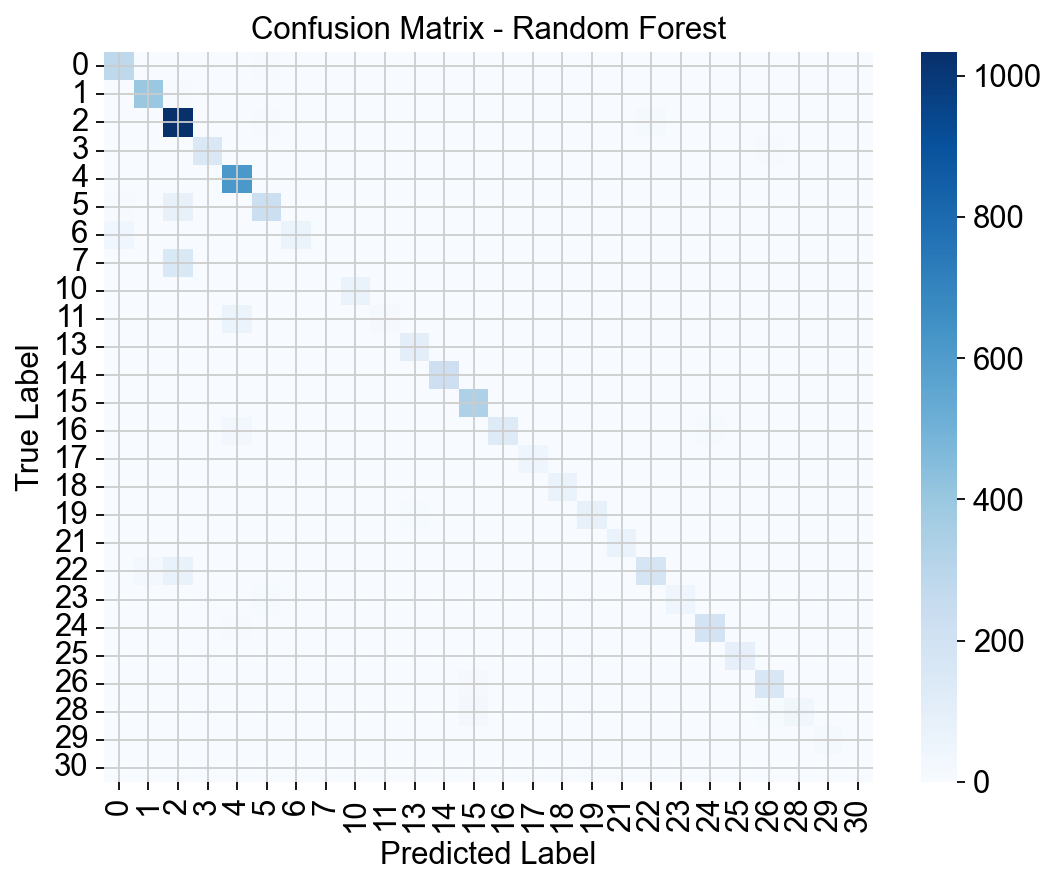

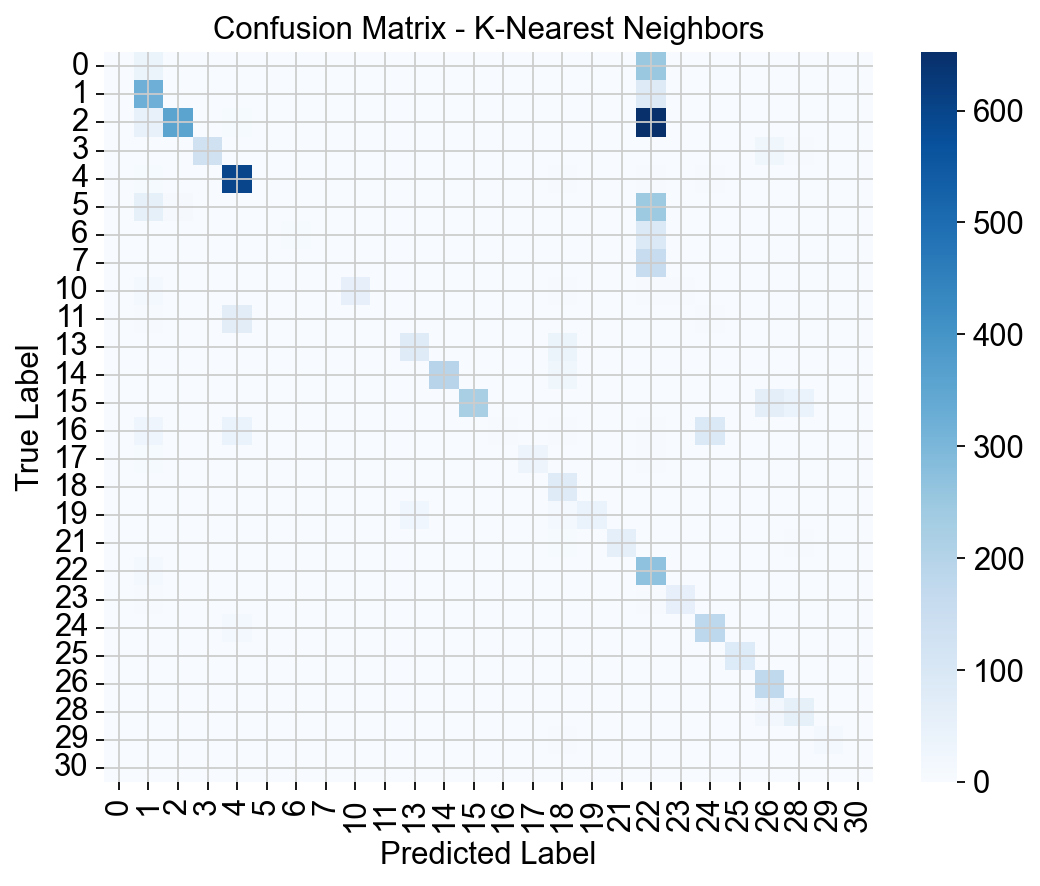

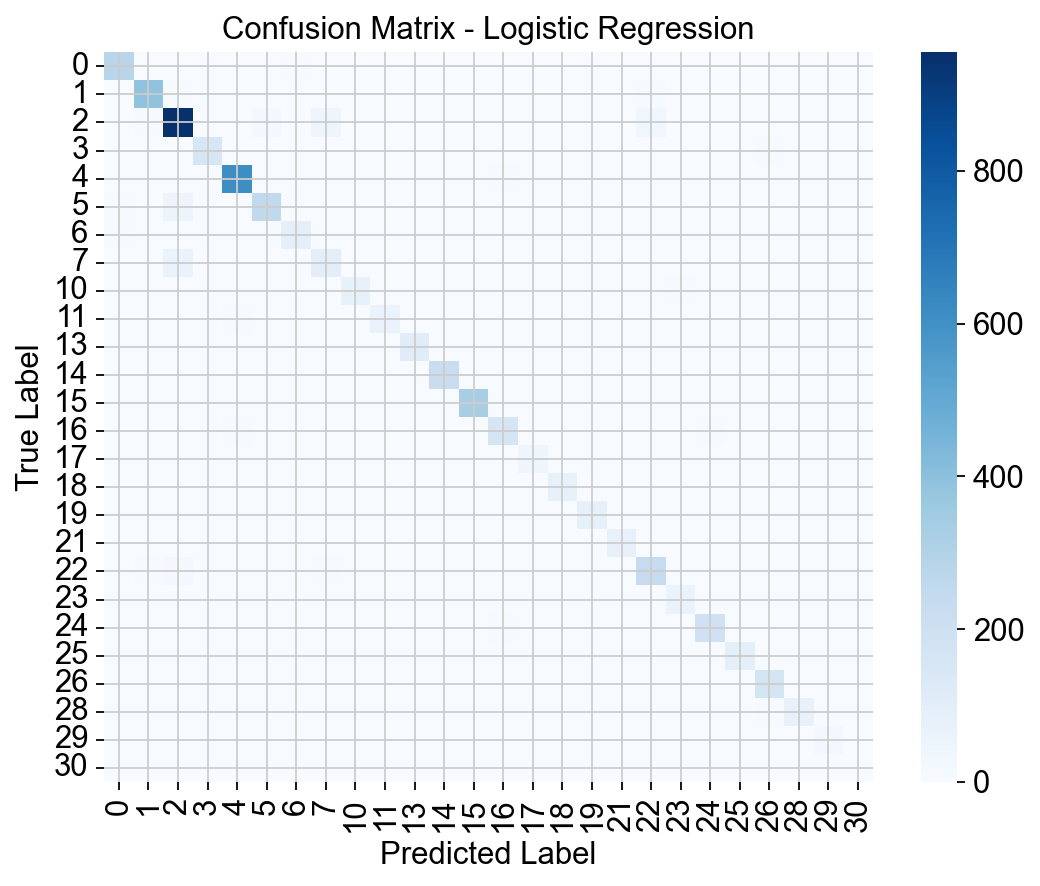

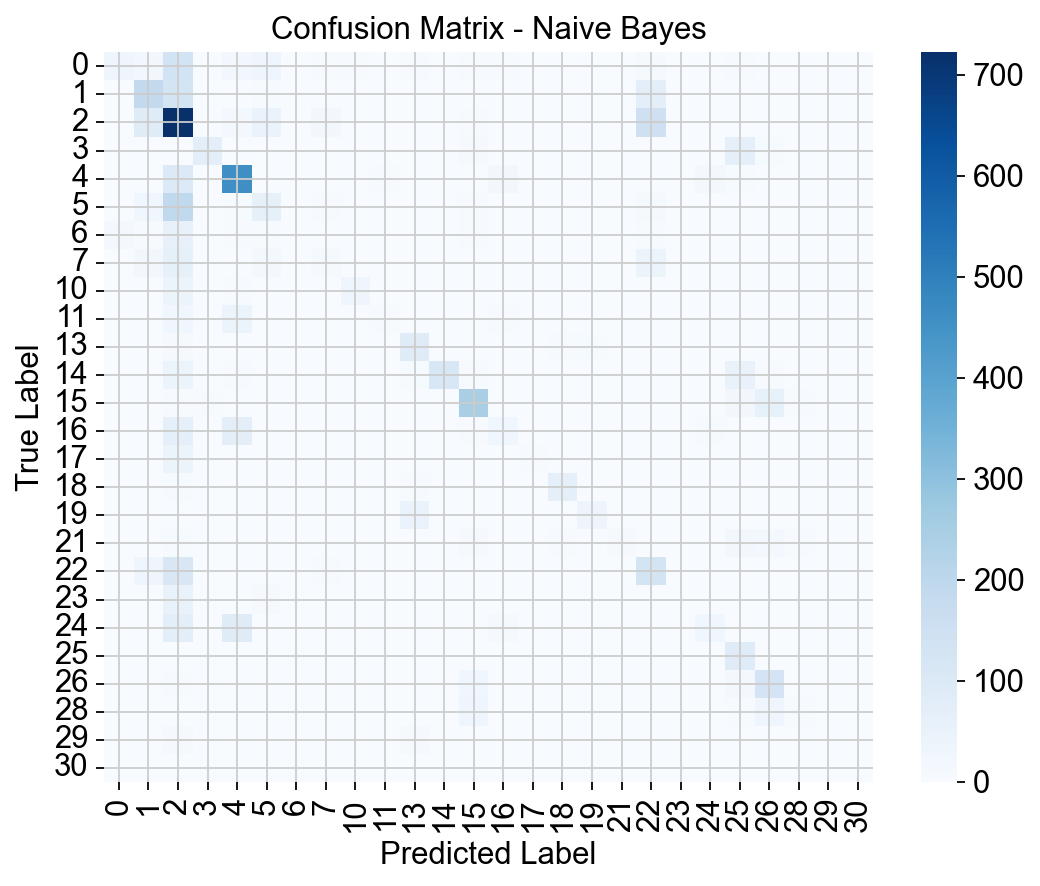

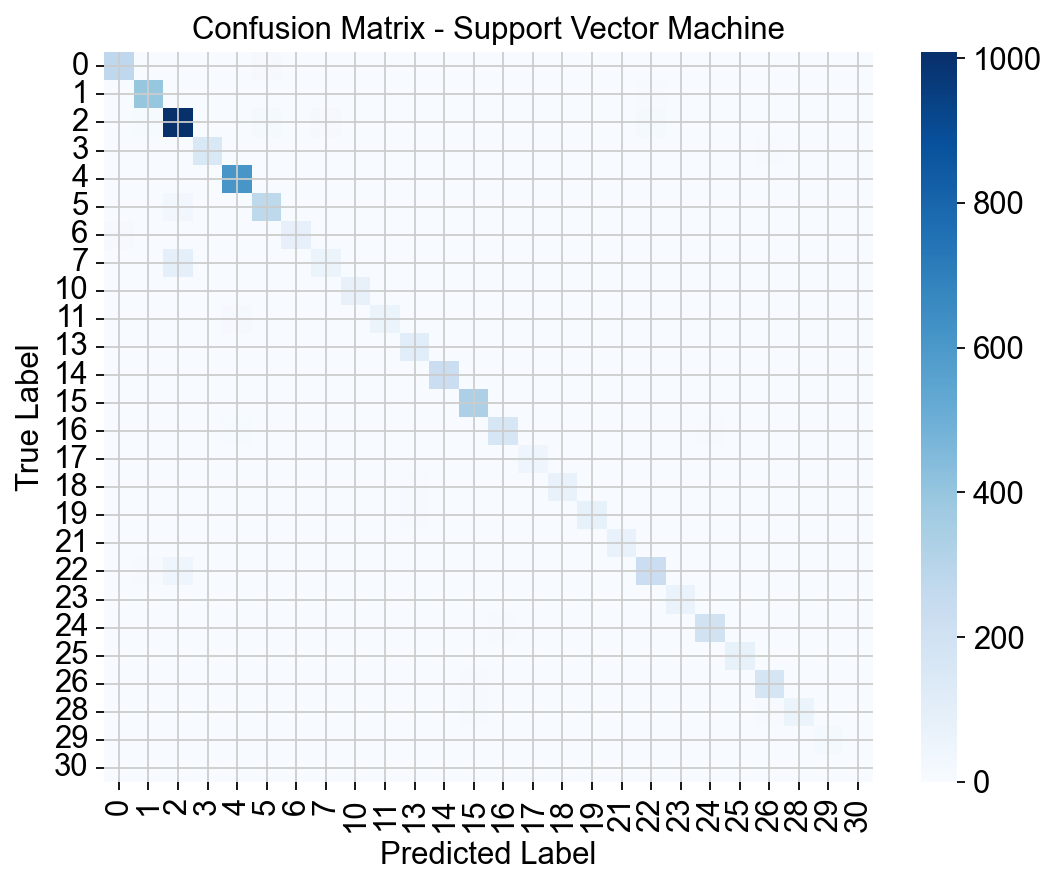

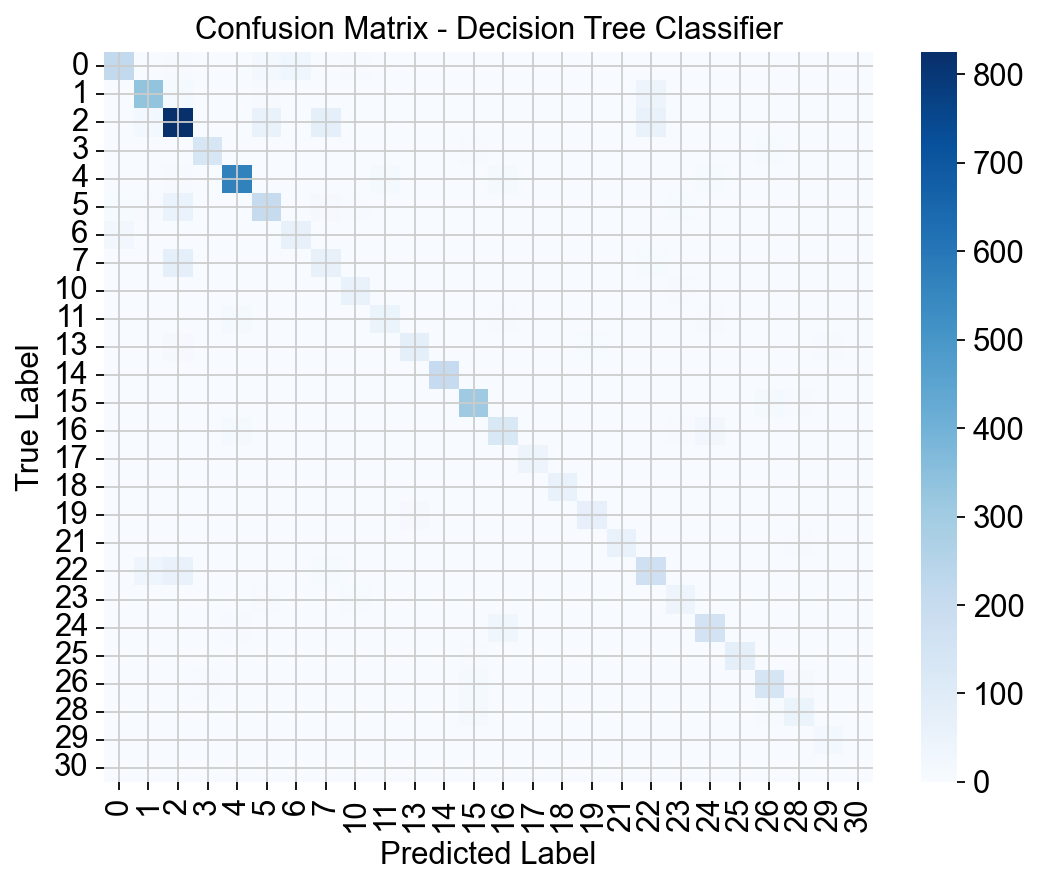

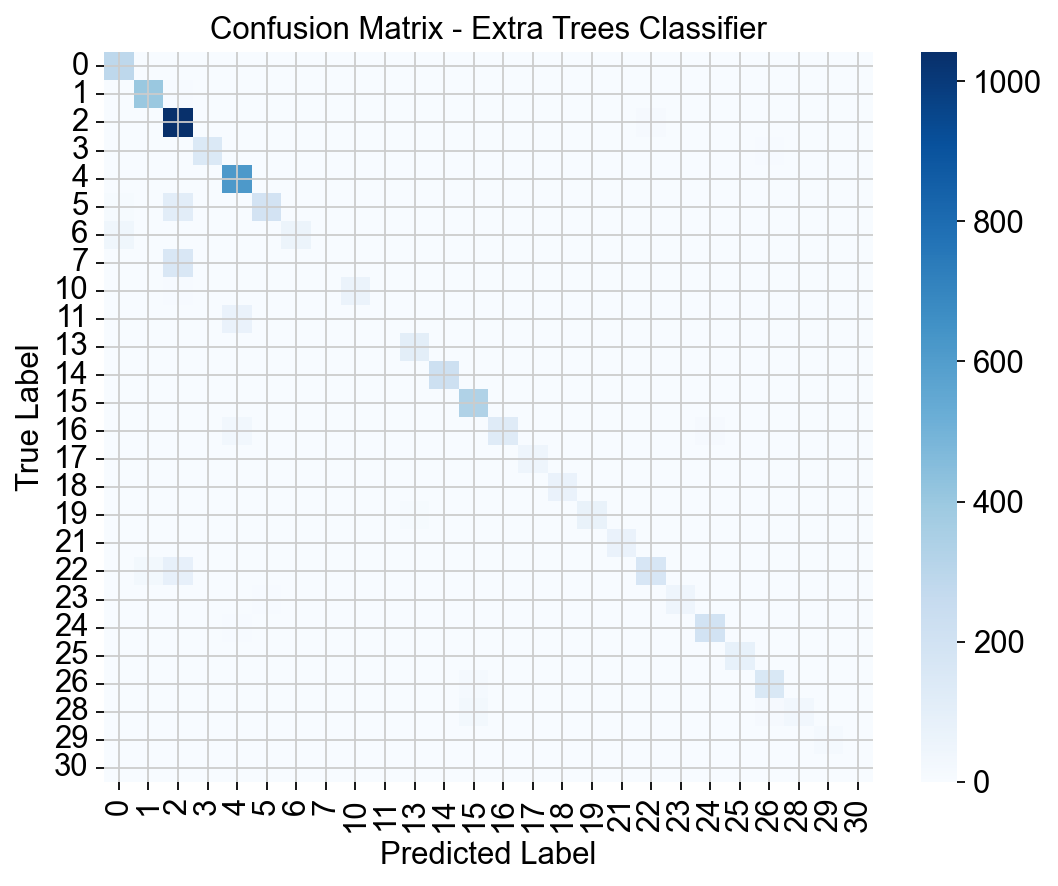

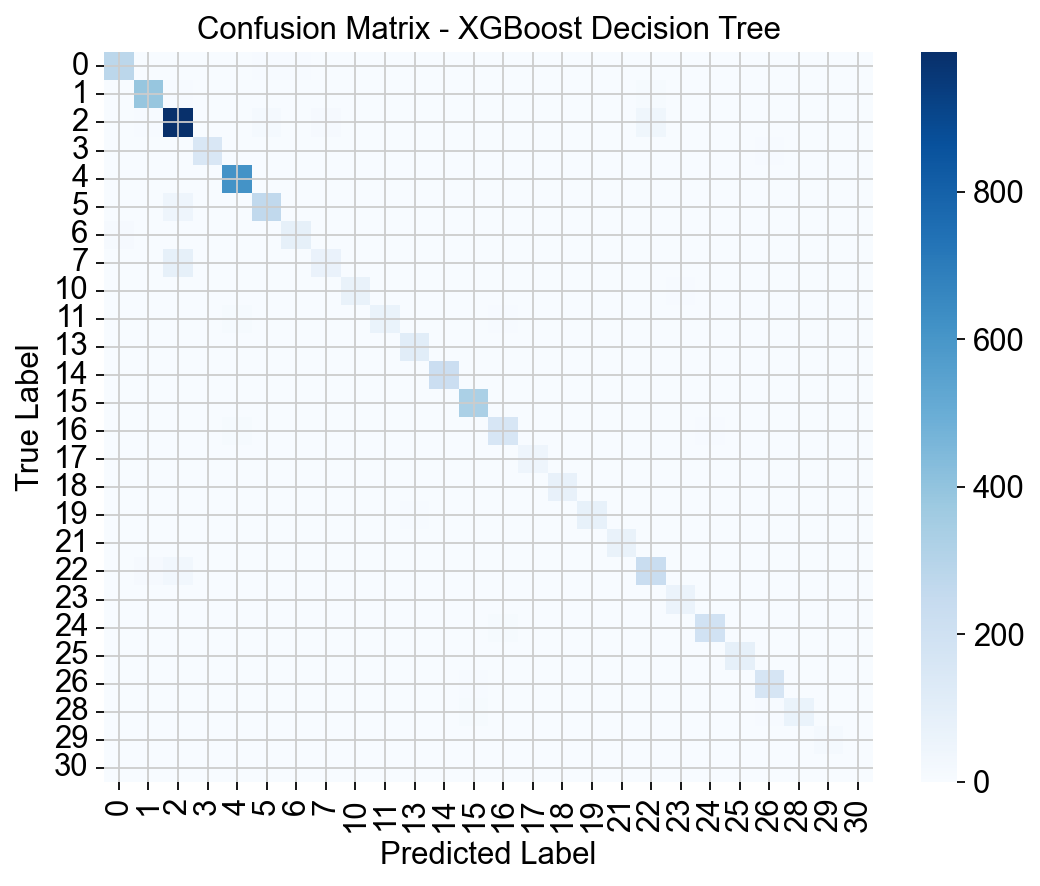

In [70]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7.7, 6))
    sb.heatmap(cm, annot=False, cmap='Blues', cbar=True,
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(test_labels, rf_pred, "Random Forest")
plot_confusion_matrix(test_labels, knn_pred, "K-Nearest Neighbors")
plot_confusion_matrix(test_labels, lr_pred, "Logistic Regression")
plot_confusion_matrix(test_labels, nb_pred, "Naive Bayes")
plot_confusion_matrix(test_labels, svc_pred, "Support Vector Machine")
plot_confusion_matrix(test_labels, decision_tree_pred, "Decision Tree Classifier")
plot_confusion_matrix(test_labels, extra_trees_pred, "Extra Trees Classifier")
plot_confusion_matrix(test_labels, XGB_decisionTree_pred, "XGBoost Decision Tree")